# Differential equation (Langevin equation)

This function g models the effect of the equation:
$$\frac{\partial \sigma_i}{\partial t}  = -\frac{\partial V}{\partial \sigma_i} +
\sum_j J_{ij} \sigma_j + h_i\sigma_i + \xi_i(t)$$

with $V = \lambda (\sigma_i^2 - 1)^2$ so that $\frac{\partial V}{\partial\sigma_i} = 4\lambda(\sigma_i^2 - 1)\sigma_i$. This term is added to ensure that $\sigma_i$ decays exponentially to either $\pm 1$ within a time $\tau \sim \frac{1}{\lambda}$

The $\xi_i(t)$ term represents Gaussian White Noise

$$ \langle \xi_i(t) \xi_j(t') \rangle = 2T\delta_{ij}\delta(t-t')$$
i.e., $\xi_i(t)$ follows a $N(0, 2T)$, there is no correlation between the noise of different spins  ($i \neq j$) and the process is Markovian and therefore has no memory (the correlation is only nonzero when $t = t'$). 

# Finite differences

Now we have to translate this differential equation into some finite difference equation. Since the neural network works with integer time increments, the exponential decay dynamics must be fast in times of order 1 and the Ising dynamics must be "slow"

$$d\sigma = \sigma_i(t+dt) - \sigma_i(t) = \left(-4\lambda(\sigma_i^2 - 1)\sigma_i + \sum_j J_{ij} \sigma_j + h_i\sigma_i \right)dt + \sqrt{2T}dW$$

absorbing 4 into $\lambda$ and clearing $\sigma_i(t+1)$:

$$g (\sigma_i(t)) = \sigma_i(t+dt)= \left(-\lambda(\sigma_i^2 - 1)\sigma_i +  \sum_j J_{ij} \sigma_j + h_i\sigma_i \right)dt + \sigma_i(t) + \sqrt{2T}dW$$

This will be our dynamical function $g (\sigma_i(t))$ defined later in the code. The noise $dW$ is now an stochastic differential of mean $\mu(dW) = 0$ and variance $\sigma^2(dW) = dt$, as commonly used.

The stationary condition can be rewritten as

$$\frac{d\sigma_i}{dt} \approx \frac{\sigma_i(t+dt) - \sigma_i(t)}{dt} = \frac{g(\sigma_i(t)) - \sigma_i(t)}{dt}$$

# Values of the dynamical parameters

 The values of the parameters are very important for the model to converge suscessfully.Too big parameter values (close or bigger than one) will cause the network to oscilate wildly trying to overcompensate the errors, while small values will converge very slowly but safely. There are another also other effects when varying $dt$ and $\lambda$.

In [1]:
import numpy as np
# Define dynamical function s(t+dt) = g(s(t))
def g(state_t0, weights):
    h = np.dot(weights, state_t0)
    xi = np.sqrt(2*T*dt)*np.random.randn(np.size(state_t0))
    state_t1 = dt*(-lamb*(state_t0**2 - 1)*state_t0 + h) + xi + state_t0
    return state_t1

According to the Hebbian rule of learning, if we want to store $K$ patterns $\{ \mathcal{P}_i^{(\mu} \}_{\mu = 1,\dots, K}$ in the network, then the weights $J_{ij}$ must be

$$J_{ij} = \frac{1}{N}\sum_{\mu=1}^K \mathcal{P}_i^{(\mu)} \mathcal{P}_j^{(\mu)}$$

$\mathcal{P}_i^{(\mu)}$ can be written as a [Hadamard matrix](https://en.wikipedia.org/wiki/Hadamard_matrix) if $L = 2^n$, the orthogonality condition for the patterns becomes, $\sum_i \mathcal{P}_i^{(\mu)} \mathcal{P}_i^{(\mu')} = 0 $ if $\mu \neq \mu'$

$N = L^2$ is the size of the newtork and $K$ is the number of stationary states of the system (memory patterns)

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
from neurodynex.hopfield_network import network, pattern_tools, plot_tools
from scipy.linalg import hadamard


def get_stationary(N, K):
    # get the first K stationary patterns of a network of size N
    # N has to be a power of two
    L = int(np.sqrt(N))
    H = np.squeeze(hadamard(N)) # Orthogonal patterns by definition
    
    if K == 1:
        H = H[0:N, L:L+1] # Get one arbitrary pattern
    else:
        H = H[0:N, 0:K]
            
    return H

def plot_evolution(states, H, L):
    """
    plot_evolution(states, H, L)
    plot evolution of states at 10 equispaced instants of a network of side L
    plot also the stationary states H
    """
    
    factory = pattern_tools.PatternFactory(L, L)
    states_as_patterns = factory.reshape_patterns(states[0:nsteps:round(nsteps/10)])
    # plot the states of the network (10 equispaced states)
    old = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = (20, 20) # Bigger size
    plot_tools.plot_pattern_list(states_as_patterns)
    plt.rcParams["figure.figsize"] = old

    # plot final state
    plot_tools.plot_pattern(np.reshape(states[-1], (L, L)))
    print('Final state')

    if len(np.shape(np.squeeze(H))) < 2:
        # only one stationary state
        plot_tools.plot_pattern(np.reshape(H, (L, L)))
        print('Stationary state')

    else:
        H_patterns = factory.reshape_patterns(H.T)
        old = plt.rcParams["figure.figsize"]
        plt.rcParams["figure.figsize"] = (20, 20) # Bigger size
        # Break into multiple lines if necessary
        for H_pattern in np.array_split(H_patterns, np.ceil(K/20),  axis=0):
            plot_tools.plot_pattern_list(H_pattern)
        plt.rcParams["figure.figsize"] = old
        print('Stationary states')
        

def iterate_plot(nsteps,  plot=False, flips=-1, pattern=-1,):
    """
    iterate_plot(nsteps, plot=False, flips=-1, pattern=-1)
    iterate nsteps and plot (if True) time evolution, final state and all stationary patterns
    flips is the number of spin flipped from the stationary pattern
    pattern is the number of the stationary pattern as given below by the function itself
    (P0, P1, P2, P3, P4, ...)
    """

    H = get_stationary(N, K)

    # create an instance of the class HopfieldNetwork
    hopfield_net = network.HopfieldNetwork(nr_neurons=N)
    # instantiate a pattern factory
    factory = pattern_tools.PatternFactory(L, L)

    # einstein summation convention, sum in lambda index (l in the code)
    hopfield_net.weights = 1/N*np.einsum('il,jl->ij', H, H)

    # set user defined function to update the state
    hopfield_net.set_dynamics_to_user_function(g)
    # hopfield_net.set_dynamics_sign_sync()

    stationary = np.squeeze(H)

    if flips == -1:
        hopfield_net.state = hopfield_net.state # random initial state
    elif pattern == -1 or K == 1:
        # flip some spins from the stat state (only one stationary state)
        hopfield_net.state = pattern_tools.flip_n(stationary, nr_of_flips=flips)
    else:
        # flip some spins from the given stat state (more than one stationary state)
        hopfield_net.state = pattern_tools.flip_n(stationary[:, pattern], nr_of_flips=flips) 

    states = hopfield_net.run_with_monitoring(nr_steps=nsteps)
    
    if plot == True:
        plot_evolution(states, H, L)
    
    return states, hopfield_net.weights



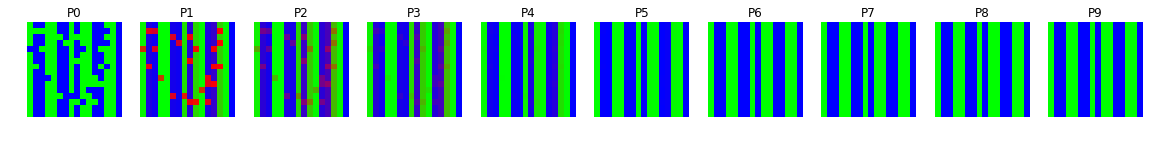

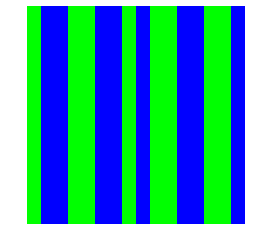

Final state


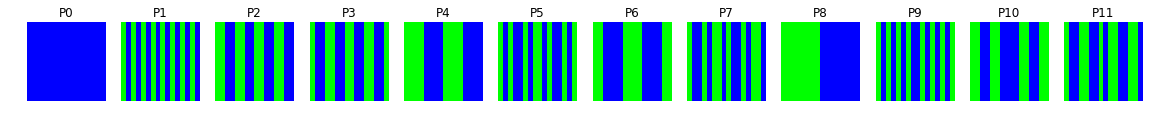

Stationary states



<Figure size 432x288 with 0 Axes>

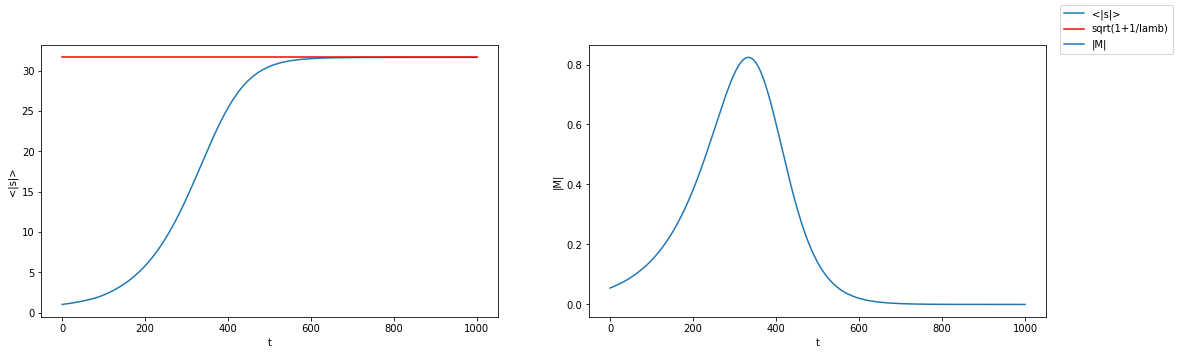

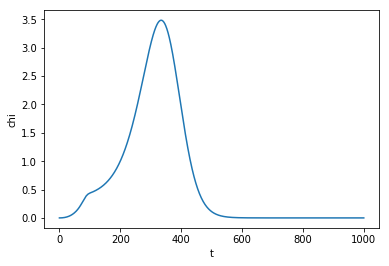

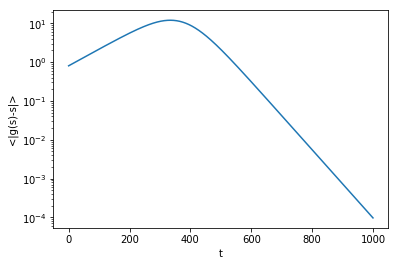

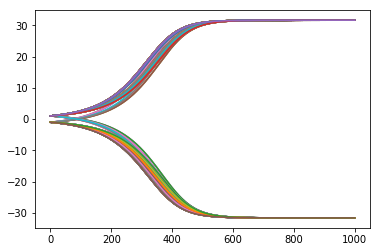

In [19]:
import matplotlib.pyplot as plt
L = 16 # size of the newtork, has to be power of two
N = L**2
K = 12 # number of memory patterns to be stored
dt = 0.01
lamb = 2.0
T = 0.0 # Temperature
nsteps = 1000 # number of steps of the simulation
naverage = 1 # number of simulations to compute average values

# for each simulation, sum the values and then divide by naverage
# for each simulation, the following variables will be:
states_sum = np.zeros([nsteps+1, N]) # value of each spin
abs_s = 0 # absoulte value of each spin averaged over the network
M = 0 # magnetization, value of each spin averaged over the network
chi = 0 # chi = <M^2> - <M^2> = var(M)
conv = 0 # |g(s(t)) -s(t)|/dt = |s(t+dt) - s(t)|/dt -> 0 @ T = 0 for a stationary state

# iterate over naverage simulations
for temp in range(0, naverage):
    states, weights = iterate_plot(nsteps, False, 25, 11)
    states_sum += states
    abs_s += np.mean(np.abs(states), axis=1)
    M += np.mean(states, axis=1)
    chi += np.var(np.abs(states), axis=1)
    conv += np.mean(np.abs([g(x, weights) - x for x in states]), axis=1)

states = states_sum/naverage
abs_s = abs_s/naverage
M = M/naverage
chi = chi/naverage
conv = conv/naverage/dt

H = get_stationary(N, K)
plot_evolution(states, H, L)

plt.figure(1)
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(18, 5))
ax1.plot(abs_s)
stat = np.sqrt(1+1/lamb) # converges to stat instead of +/- 1
ax1.plot([0, len(abs_s)], [stat, stat], 'r')
ax1.set_xlabel('t')
ax1.set_ylabel('<|s|>')
ax2.plot(np.abs(M))
ax2.set_xlabel('t')
ax2.set_ylabel('|M|')
fig.legend(['<|s|>', 'sqrt(1+1/lamb)', '|M|'])

# E = -np.einsum('ik->k', np.einsum('ij,kj->ik', weights, states))
# plt.figure(2)
# plt.plot(E)
# plt.xlabel('t')
# plt.ylabel('E')

plt.figure(4)
plt.plot(chi)
plt.xlabel('t')
plt.ylabel('chi')

plt.figure(5)
plt.semilogy(conv)
plt.xlabel('t')
plt.ylabel('<|g(s)-s|>')

plt.figure(6)
plt.plot(states)
print("")



Convergence to $\pm 1$ (rerun the cell above, bigger nsteps may be needed with increasing $\lambda$)

| $\lambda$ | 0.125 | 0.25 | 0.5 | 1.0 | 2.0 |
|-----------|-------|------|-----|-----|-----|
|   $|s|$   |  3.0  |  2.2 | 1.7 | 1.4 | 1.2 |




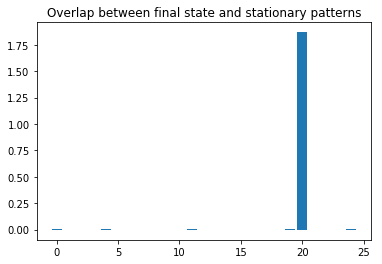

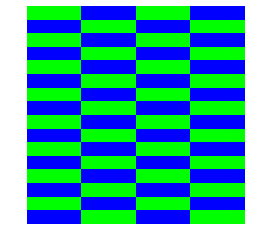

Final state


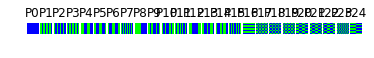

/home/julian/.virtualenvs/hopfield/local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


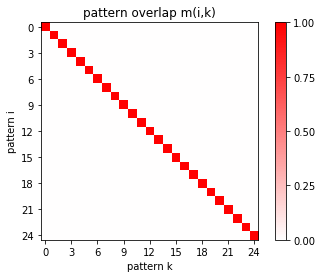

0.0

In [56]:
plt.figure(1)
H = get_stationary(N, K)
overlap = [pattern_tools.compute_overlap(states[-1], x) for x in H.T]
plt.bar(np.arange(0, K), overlap)
plt.title('Overlap between final state and stationary patterns')
metastable = np.dot(overlap, H.T) # Reconstruct metastable pattern
plot_tools.plot_pattern(np.reshape(metastable, (L, L)))
print("Final state")

# check that overlap_matrix is diagonal
factory = pattern_tools.PatternFactory(L, L)
pattern_list = factory.reshape_patterns(H.T)
plot_tools.plot_pattern_list(pattern_list)
# how similar are the random patterns and the checkerboard? Check the overlaps
overlap_matrix = pattern_tools.compute_overlap_matrix(pattern_list)
plot_tools.plot_overlap_matrix(overlap_matrix)
np.sum(np.abs(overlap_matrix-np.eye(len(H.T)))) # 0 for diagonal overlap_matrix

In [58]:
A = np.array((1,2,3,4,5,6,7,8,9))

In [61]:
for x in np.array_split(A, 2):
    print(x)

[1 2 3 4 5]
[6 7 8 9]


In [78]:
H = get_stationary(N, K)
H = np.reshape(H, (25, 16, 16))
for x in np.array_split(H, np.ceil(K/20),  axis=0):
    print(np.shape(x))

(13, 16, 16)
(12, 16, 16)


In [77]:
np.ceil(K/20)

1.25